## 利用するPythonモジュールのインポート

In [ ]:
import numpy as np  # データサイエンスの定番モジュール
import scipy as sp  # 科学技術計算で頻用するツールを集めたモジュール
import matplotlib.pyplot as plt  # 可視化ツール
from scipy.integrate import odeint  # 常微分方程式を数値積分する関数

## グラフ描画の関数

In [ ]:
def plot2d(t, y_list, t_label, y_label, legend_list):
    plt.figure(figsize=(12,8)) # 描画サイズ
    plt.xlabel(t_label)  # x軸のラベル
    plt.ylabel(y_label)  # y軸のラベル
    plt.grid()  # 点線の目盛りを表示

    for i in range(y_list.shape[1]):
        plt.plot(t, y_list[:, i], label=legend_list[i])

    plt.legend(loc = "upper right") # 凡例の表示
    plt.show()


def sv_plot(xy_list, Vmax_line, Km_point=False):
    Vmax_half_line = Vmax_line/2.0 # Vmaxの1/2の反応速度

    plt.figure(figsize=(12,8)) # 描画サイズ

    for i, p in enumerate(xy_list):
        plt.plot(p[0], p[1], label=f'condition {i}') # x軸を基質濃度、y軸を反応速度でプロット

    if Km_point:
        plt.axhline(Vmax_half_line, c='black',ls='--') # y = Vmax_half (Vmax/2) に点線を引く

    plt.xlabel('$s$ (M)') # x軸のラベル
    plt.ylabel('v (M/$t$)') # y軸のラベル

    plt.grid() # 点線の目盛りを表示
    plt.legend() # 凡例の表示
    plt.axhline(Vmax_line, c='black',ls='--') # y = Vmax に点線を引く


def compare_plot(t, y_list, t_label, y_label, legend_list):

    for i in range(y_list.shape[2]): # 物質の index
        plt.figure(figsize=(12,8)) # 描画サイズ

        for j in range(y_list.shape[0]): # condition の　index
            plt.plot(t, y_list[j][:, i], label=f'conditon {j}')

        plt.title(legend_list[i])
        plt.xlabel(t_label)  # x軸のラベル
        plt.ylabel(y_label)  # y軸のラベル
        plt.grid()  # 点線の目盛りを表示
        plt.legend() # 凡例の表示
        plt.show()

# 阻害剤存在下の酵素反応速度論
$$\require{mhchem}$$
* 酵素や酵素-基質複合体に結合して酵素の活性を下げる物質を**阻害剤**と呼ぶ。
* このノートブックでは、可逆的阻害の中から**競合的阻害**について解説する。

## ミカエリス・メンテン式による酵素反応

* 酵素反応における酵素の反応速度と基質濃度の関係を表現するモデルに**ミカエリス・メンテン式** **Michaelis–Menten equation**　がある。
* このモデルでは、**酵素 Enzyme** と**基質 Substance** が結合した**酵素-基質複合体 Enzyme-Substance Complex** を形成することにより酵素反応が進行するという概念に基づき、**生成物 Product** を生成する一連の反応機構を以下のように仮定する

$$\ce{E + S <=>[k_{1}][k_{-1}] ES ->[k_{2}] E + P} \tag{1.1}$$

> * **酵素**：$\ce{E}$
> * **基質**：$\ce{S}$
> * **酵素-基質複合体**：$\ce{ES}$
> * **生成物**：$\ce{P}$
> * **速度定数** $k_{1}$, $k_{-1}$, $k_{2}$ ：反応の進みやすさを表す。


* この酵素反応に関わる $\ce{E}$、$\ce{S}$、$\ce{ES}$、$\ce{P}$ の濃度変化速度は以下のように書ける。

$$
\begin{eqnarray}
    \frac{d\ce{E}}{dt} &=& -k_{1}[\ce{E}][\ce{S}] + (k_{-1}+k_{2})[\ce{ES}] \tag{1.2}\\
    \frac{d\ce{S}}{dt} &=& -k_{1}[\ce{E}][\ce{S}] + k_{-1}[\ce{ES}] \tag{1.3}\\
    \frac{d\ce{ES}}{dt} &=& k_{1}[\ce{E}][\ce{S}] - (k_{-1}+k_{2})[\ce{ES}] \tag{1.4}\\
    \frac{d\ce{P}}{dt} &=& k_{2}[\ce{ES}] \tag{1.5}
\end{eqnarray}
$$ 

* $(1.1)$ で表される酵素反応では、反応の初速度 $v_{0}$と基質 $\ce{S}$ のモル濃度の間には、一般に以下の式が成り立つ。

$$v_{0} = \frac{V_{\ce{max}}[\ce{S}]}{K_\ce{m}+[\ce{S}]} \tag{1.6}$$ 

> * **最大反応速度**：$V_{\ce{max}}$
> * **ミカエリス定数**：$K_{\ce{m}}$（$V_{\ce{max}}$の 1/2 の速度を与える基質濃度に相当）

* $(1.6)$ を**ミカエリス・メンテン式** **Michaelis–Menten equation** と呼ぶ。

## 競合的阻害 Competitive inhibition
* **ミカエリス・メンテン式**による酵素反応モデルにおいて、**阻害剤 Inhibitor** が酵素の基質結合部に結合することで、基質と阻害剤が酵素の活性部位を奪い合う状況を **競合的阻害** という。
* 基質と阻害剤が同時に酵素に結合することは想定しない。

> * **酵素**：$\ce{E}$
> * **基質**：$\ce{S}$
> * **酵素-基質複合体**：$\ce{ES}$
> * **生成物**：$\ce{P}$
> * **阻害剤**：$\ce{I}$
> * **酵素-阻害剤複合体**：$\ce{EI}$
> * **速度定数** $k_{1}$, $k_{-1}$, $k_{2}$ ：反応の進みやすさを表す。
> * **平衡定数**： $K_\ce{i}$

* 競合的阻害剤が存在している場合、反応の初速度 $v_{0}$と基質 $\ce{S}$ のモル濃度の間には、一般に以下の式が成り立つ。

$$v_{0} = \frac{V_{\ce{max}}[\ce{S}]}{K_\ce{m}(1+\frac{[\ce{I}]}{K_\ce{i}})+[\ce{S}]} \tag{2.1}$$ 



* この酵素反応に関わる $\ce{E}$、$\ce{S}$、$\ce{ES}$、$\ce{P}$, $\ce{I}$, $\ce{EI}$ の濃度変化速度は以下のように書ける。

$$
\begin{eqnarray}
    \frac{d\ce{E}}{dt} &=& -k_{1}[\ce{E}][\ce{S}] - [\ce{E}][\ce{I}] + (k_{-1}+k_{2})[\ce{ES}] + [\ce{EI}]\tag{2.2}\\
    \frac{d\ce{S}}{dt} &=& -k_{1}[\ce{E}][\ce{S}] + k_{-1}[\ce{ES}] \tag{2.3}\\
    \frac{d\ce{ES}}{dt} &=& k_{1}[\ce{E}][\ce{S}] - (k_{-1}+k_{2})[\ce{ES}] \tag{2.4}\\
    \frac{d\ce{P}}{dt} &=& k_{2}[\ce{ES}] \tag{2.5}\\
    \frac{d\ce{I}}{dt} &=& - [\ce{E}][\ce{I}] + [\ce{EI}] \tag{2.6}\\
    \frac{d\ce{EI}}{dt} &=&  [\ce{E}][\ce{I}] - [\ce{EI}] \tag{2.7}\\
\end{eqnarray}
$$ 

### 競合的阻害のミカエリス・メンテン式の導出

* **（仮定１）**： $[\ce{S}]$ が高濃度の場合、酵素反応の第一段階は $k_{1} \gg k_{2}$ となり、$[\ce{ES}]$ は定常状態に達する。
* この反応系の律速段階は、$\ce{ES ->[k_{2}] E + P}$ となる。
* そのため、[$\ce{P}$] を生成する反応速度 $v$ は、以下の式で表せる。

$$v_0 = k_{2}[\ce{ES}] \tag{2.8}$$

* **（仮定２）**： このモデルにおいて、$[\ce{ES}]$ が時間変化しない定常状態に短時間で達するものとする。
* $[\ce{ES}]$が定常状態の時、$(4)$は以下の式で表すことができる。

$$\frac{d\ce{ES}}{dt} =  k_1[\ce{E}][\ce{S}] - (k_{-1} + k_{2})[\ce{ES}]=0 \tag{2.9}$$

* **（仮定３）**： このモデルにおいて、反応開始直後に $[\ce{I}]$ はすぐ $[\ce{E}]$ と結合して、$\ce{E + I <=>EI}$ は平衡状態となる。
* この時、平衡定数 $K_\ce{i}$ は以下で示される。

$$\ce{K_{i} = \frac{[E][I]}{[EI]}} \tag{2.10}$$


* この反応系の酵素の総濃度を $[\ce{E}]_0$ とすると、以下の式で表せる。

$$[\ce{E}]_0 = [\ce{E}] + [\ce{ES}] + [\ce{EI}] \tag{2.11}$$

* $(2.11)$を $[\ce{ES}]$ について整理し、$(2.8)$ に代入する。

$$v_0 = k_{2}([\ce{E}]_0 - [\ce{E}] - [\ce{EI}]) \tag{2.12}$$

* ここから濃度が既知である $[\ce{E}]_0$、$[\ce{S}]$、$[\ce{I}]$で $(2.12)$ を示すことを目指す。

* $(2.8)$ を $[\ce{E}]$について整理すると、

$$[\ce{E}] = \frac{(k_{-1} + k_{2})[\ce{ES}]}{k_1[\ce{S}] } =  \frac{K_\ce{m}[\ce{ES}]}{[\ce{S}] }\tag{2.13}$$
> * $K_{\ce{m}} = \frac{k_{-1}+k_{2}}{k_{1}}$

* $(2.10)$ を $[\ce{EI}]$ について整理し、$[\ce{E}]$ に $(2.13)$ を代入する。

$$[\ce{EI}] = \frac{K_\ce{m}[\ce{ES}][\ce{I}]}{[\ce{S}]K_\ce{i} }\tag{2.14}$$

* $(2.13)$、$(2.14)$ を $(2.11)$ に代入して、右辺を $[\ce{ES}]$ でくくる。

$$[\ce{E}]_0 = [\ce{ES}](\frac{K_\ce{m}}{[\ce{S}] } + \frac{K_\ce{m}[\ce{I}]}{[\ce{S}]K_\ce{i} } + 1) \tag{2.15}$$

* (　)内を以下のように整理する。
    * $\frac{1}{[\ce{S}]}$でくくる。
    * 第１項と第２項を $K_\ce{m}$ でくくる。
* その後、$[\ce{ES}]$ について解く。

$$[\ce{ES}] = \frac{[\ce{E}]_0[\ce{S}]}{K_\ce{m}(1+\frac{[\ce{I}]}{K_\ce{i}})+[\ce{S}]} \tag{2.16}$$

* $(2.8)$ の $[\ce{ES}]$ に $(2.16)$ を代入すると $(2.1)$ が導出できる。

$$v_{0} = \frac{V_{\ce{max}}[\ce{S}]}{K_\ce{m}(1+\frac{[\ce{I}]}{K_\ce{i}})+[\ce{S}]} \tag{2.1}$$ 

> * $V_{\ce{max}} = k_{2}[\ce{E}]_0$

## 競合的阻害のミカエリス・メンテンの数値計算 / 阻害なしの場合との比較

In [ ]:
class Michaelis_menten_competitive_inhibit():

    def __init__(self, s, t, k, legend_list):
        self.s = s
        self.t = t
        self.k = k
        self.legend_list = legend_list
        self.vmax = k[2] * s[0]
        self.km = (k[1] + k[2])/k[0]

    def ode_simulation(self):
        return odeint(self._mass_action, self.s, self.t, args=(self.k[0], self.k[1], self.k[2], self.k[3], self.k[4]))  # 数値計算を実行し、結果を返す

    def _mass_action(self, s, t, k1, k_1, k2, k3, k_3):

        """
        引数 s  ：基質濃度の配列 [ Eの濃度, Sの濃度, ESの濃度, Pの濃度, Iの濃度、EIの濃度 ]
        引数 t  ：時刻
        引数 k1 ： E + S -> ES の速度定数
        引数 k_1 ： ES -> E + S の速度定数
        引数 k2 ： ES -> E + P の速度定数
        引数 k3 ： E + I -> EI の速度定数
        引数 k_3 ： EI -> E + I の速度定数
        """

        # 各物質濃度の情報    
        E  = s[0]
        S  = s[1]
        ES = s[2]
        P  = s[3]
        I   = s[4]
        EI  = s[5]

        # 反応速度式
        V_R1_f = k1 * E * S
        V_R1_r = k_1 * ES
        V_R2 = k2 * ES
        V_R3_f = k3 * E * I
        V_R3_r = k_3 * EI

        # 物質収支式
        dEdt  = - V_R1_f - V_R3_f + V_R1_r + V_R2 + V_R3_r
        dSdt  = - V_R1_f + V_R1_r
        dESdt = V_R1_f - V_R1_r - V_R2
        dPdt  = V_R2
        dIdt = - V_R3_f + V_R3_r
        dEIdt = V_R3_f - V_R3_r

        return [dEdt, dSdt, dESdt, dPdt, dIdt, dEIdt]

    
    def michaelis_menten_eq(self, S, I): # ミカエリス・メンテン式の関数
        '''
        入力：S（基質濃度）、Vmax（最大反応速度）、Km（ミカエリス定数）
        出力：反応速度
        '''
        if I == 0.0:
            return self.vmax * S /(self.km + S)
        else:
            return self.vmax * S /(self.km*(1+I/self.ki) + S)

    @property
    def ki(self):

        index = [0, 4, 5] # 0: E, 4: I, 5:EI 
        balance_values = []
        timecourse = self.ode_simulation()

        for i in index:
            seq = timecourse[:, i]
            balance_values.append(seq[-1])

        return self.k[3]*(balance_values[0] * balance_values[1]) / self.k[4]*balance_values[2]

    @property
    def sv(self):
        timecourse = self.ode_simulation()
        s_timecourse = timecourse[:, 1] # 基質（S） の時系列データ
        i_timecourse = timecourse[:, 4] # 阻害剤(I) の時系列データ
        y_velocity = np.array([ self.michaelis_menten_eq(s_timecourse[i], i_timecourse[i])for i in range(len(s_timecourse)) ]) # S の時系列データに対応する反応速度データ

        return [s_timecourse, y_velocity] # [x軸(基質の時系列データ), y軸（反応速度データ）]

In [ ]:
# シミュレーションの準備
t_condition = np.linspace(0.0, 1000.0, 1000)  # 時刻0から1000を、1000ステップで数値計算
legend_list = ["E", "S", "ES", "P", "I", "EI"]

k = [0.5, 0.1, 0.05, 1.0, 1.0] # 速度定数をまとめたリスト

'''
Index: 対象の速度定数
0: E + S -> ES の速度定数
1: ES -> E + S の速度定数
2: ES -> E + P の速度定数
3: E + I -> EI の速度定数
4: EI -> E + I の速度定数
'''


'\nIndex: 対象の速度定数\n0: E + S -> ES の速度定数\n1: ES -> E + S の速度定数\n2: ES -> E + P の速度定数\n3: E + I -> EI の速度定数\n4: EI -> E + I の速度定数\n'

### 全物質濃度の時系列データでの比較

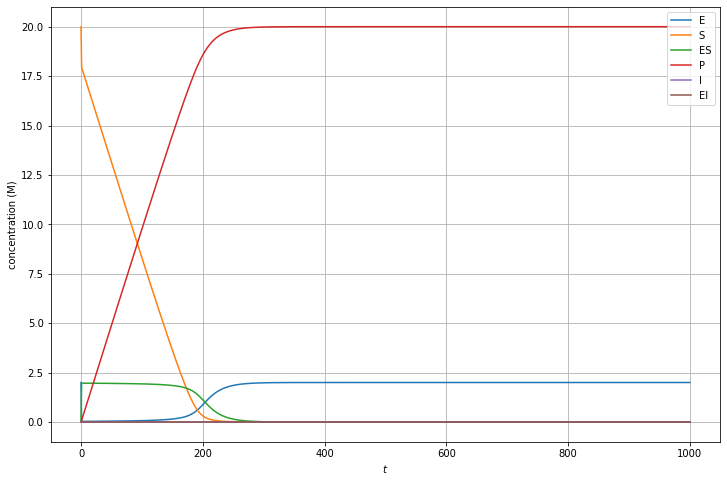

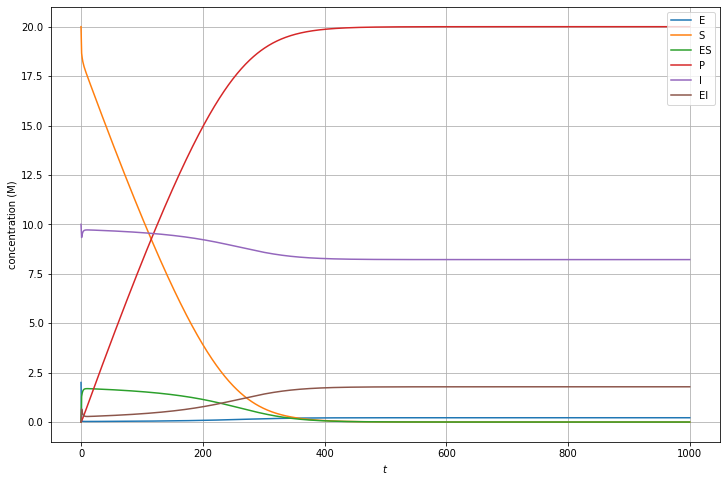

In [ ]:
# 通常のミカエリス・メンテンの酵素反応
sp_0 = [2.0, 20.0, 0.0, 0.0, 0.0, 0.0] # 物質 E, S, ES, P, I, EIの初期濃度
mm0 = Michaelis_menten_competitive_inhibit(sp_0, t_condition, k, legend_list)
mm0_timecourse = mm0.ode_simulation()
plot2d(t_condition, mm0_timecourse, "$t$", "concentration (M)", legend_list)

# 競合的阻害のミカエリス・メンテンによる酵素反応
sp_0 = [2.0, 20.0, 0.0, 0.0, 10.0, 0.0] # 物質 E, S, ES, P, I, EIの初期濃度
mm1 = Michaelis_menten_competitive_inhibit(sp_0, t_condition, k, legend_list)
mm1_timecourse = mm1.ode_simulation()
plot2d(t_condition, mm1_timecourse, "$t$", "concentration (M)", legend_list)

### 各物質濃度別の時系列データでの比較

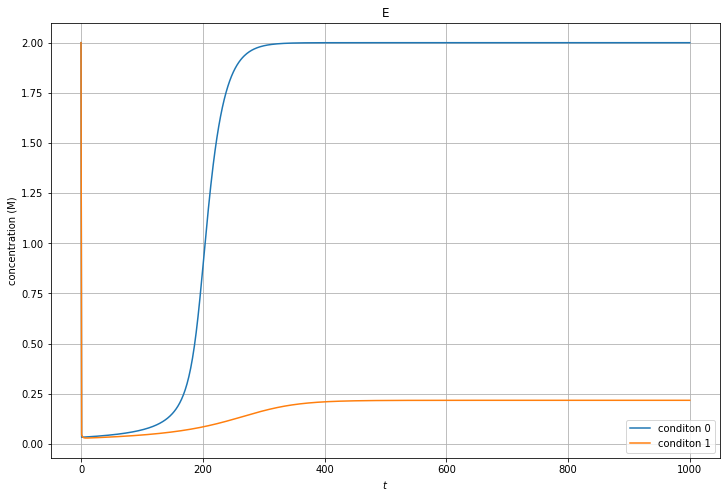

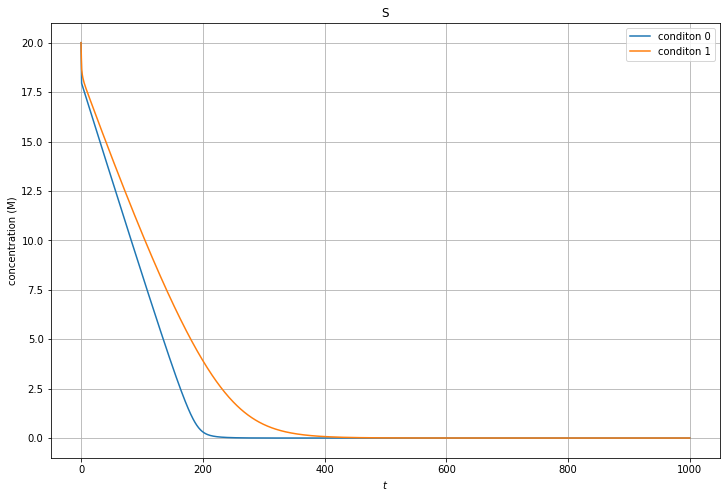

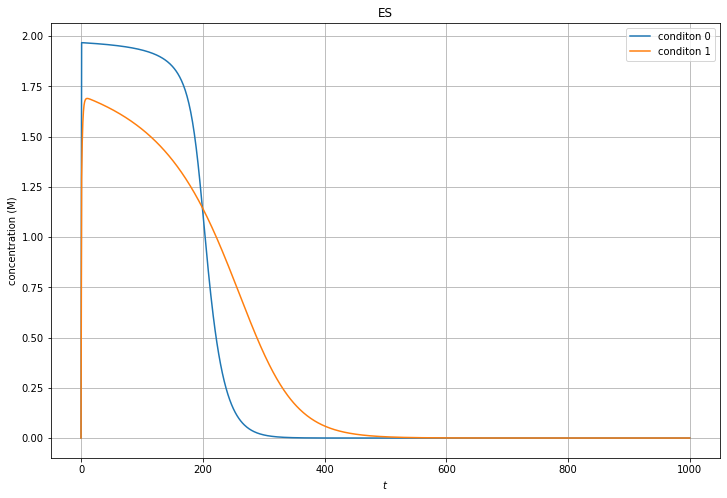

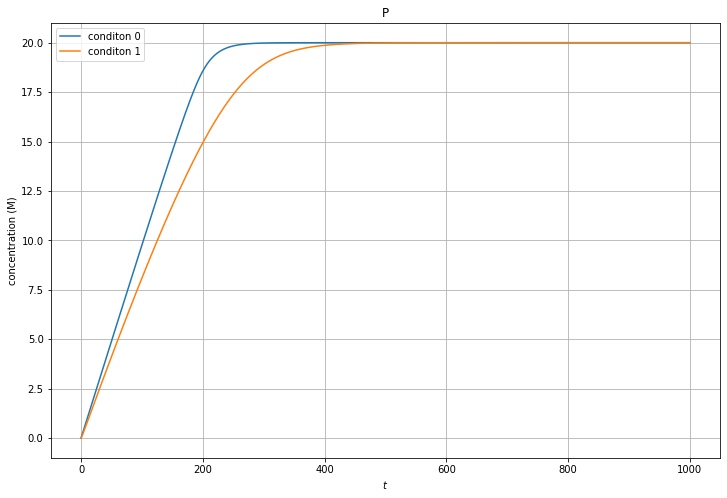

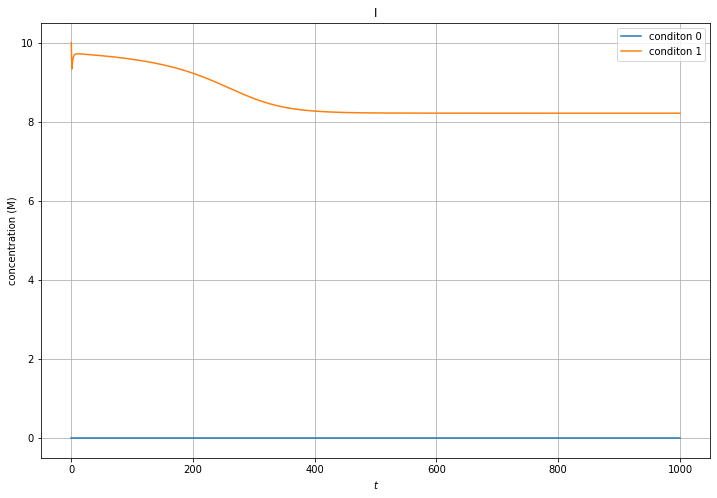

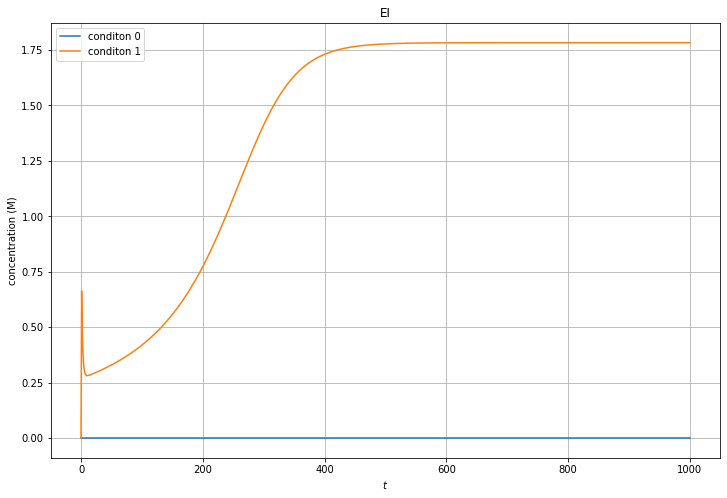

In [ ]:
data_list = np.array([mm0_timecourse, mm1_timecourse])
compare_plot(t_condition, data_list, "$t$", "concentration (M)", legend_list)

### ミカエリス・メンテンプロット (S-Vプロット) での比較

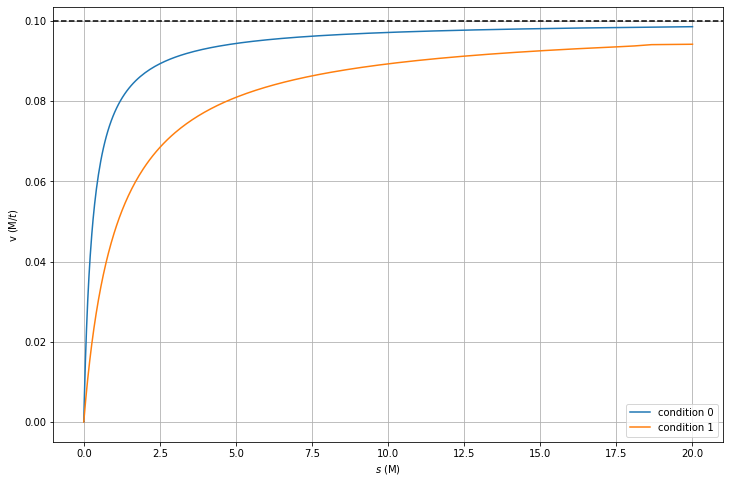

In [ ]:
sv_plot([mm0.sv, mm1.sv], mm0.vmax)

## 参考資料
* **NumPy** - https://numpy.org/

* **SciPy** - https://docs.scipy.org/doc/scipy
    * **scipy.integrate** https://docs.scipy.org/doc/scipy/reference/integrate

* **matplotlib** - https://matplotlib.org/
  * Python でグラフを描くための定番パッケージ

* **Easy Copy Mathjax** - https://easy-copy-mathjax.nakaken88.com
  * Jupyterノートブックに数式を書き込むのに使えるMathjaxのチートシート

* **mhchem** - http://mirrors.ctan.org/macros/latex/contrib/mhchem/mhchem.pdf
  * Mathjaxに実装されている化学式、化学反応式を書くための $\TeX$ パッケージ。
  * [TeXによる化学組版](https://doratex.hatenablog.jp/entry/20131203/1386068127) mhchem の解説記事（TeX Alchemist Online）

* *酵素阻害剤* - https://ja.wikipedia.org/wiki/%E9%85%B5%E7%B4%A0%E9%98%BB%E5%AE%B3%E5%89%A4
    * 競合的阻害 - https://ja.wikipedia.org/wiki/%E7%AB%B6%E5%90%88%E9%98%BB%E5%AE%B3
    * 非競合的阻害 - https://ja.wikipedia.org/wiki/%E9%9D%9E%E7%AB%B6%E5%90%88%E9%98%BB%E5%AE%B3
    * 不競合的阻害 - https://ja.wikipedia.org/wiki/%E4%B8%8D%E7%AB%B6%E5%90%88%E9%98%BB%E5%AE%B3
    * 混合阻害 - https://ja.wikipedia.org/wiki/%E6%B7%B7%E5%90%88%E9%98%BB%E5%AE%B3
    